# Interactive Visualisation of Toffee Data

Through the `ToffeeFragmentsPlotter` we can start to explore the raw data contained within a toffee file. These plots are specifically aimed at extracting the same data that one might use when calculating scores in a DIA-pipeline such as `OpenMSToffee`. There are also highly useful for manually validating results, for example when investigating missing values in a broader downstream analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

from IPython.display import SVG

import pandas as pd

import plotly
import plotly.offline as po

import toffee
from toffee.util import calculate_isotope_mz
from toffee.viz import ToffeeFragmentsPlotter

po.init_notebook_mode(connected=True)

In [3]:
toffee.__version__

'0.12.18'

In [4]:
base_dir = os.environ.get('DIA_TEST_DATA_REPO', None)
assert base_dir is not None

For this purpose, we are specifically using a spectral library to define the precursor/product mass over charge ratios

In [5]:
columns = [
    'PrecursorMz',
    'ProductMz',
    'LibraryIntensity',
    'ProteinId',
    'PeptideSequence',
    'ModifiedPeptideSequence',
    'TransitionGroupId',
    'TransitionId'
]
srl = pd.read_csv(base_dir + '/ProCan90/srl/hek_srl.OpenSwath.iRT.tsv', sep='\t')

so that we can calculate the C12/C13 isotope offsets and use these in our visualisation.

In [6]:
n_isotopes = 2
precursors, products = calculate_isotope_mz(
    precursor_and_product_df=srl,
    n_isotopes=n_isotopes,
    sort_by_intensity=True,
)
precursors.set_index('Id', inplace=True)
products.set_index('GroupId', inplace=True)

Constructing the plotters is very simple and requires a path to an existing toffee file.

In [7]:
plotter = ToffeeFragmentsPlotter(
    base_dir + '/ProCan90/tof/ProCan90-M06-07.tof',
    use_ms1=True,
)

Finally, we can extract out the mass over charge values for specific transition groups and plot these out. In this example, we have picked out the retention time of the peak so that the plots can be zoomed in

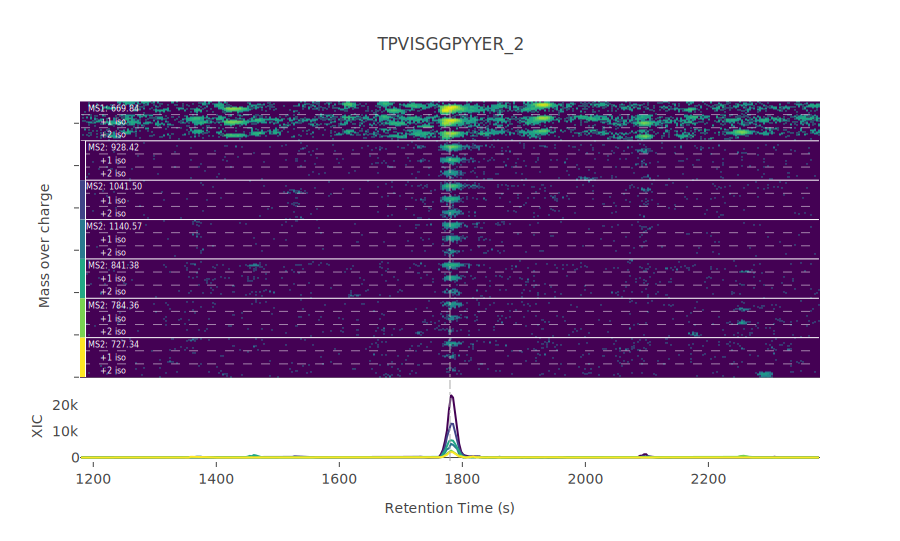

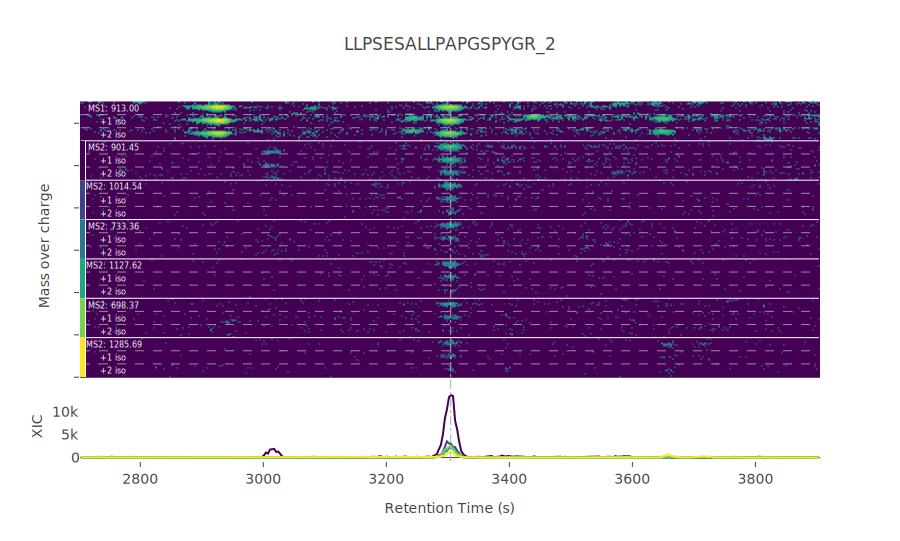

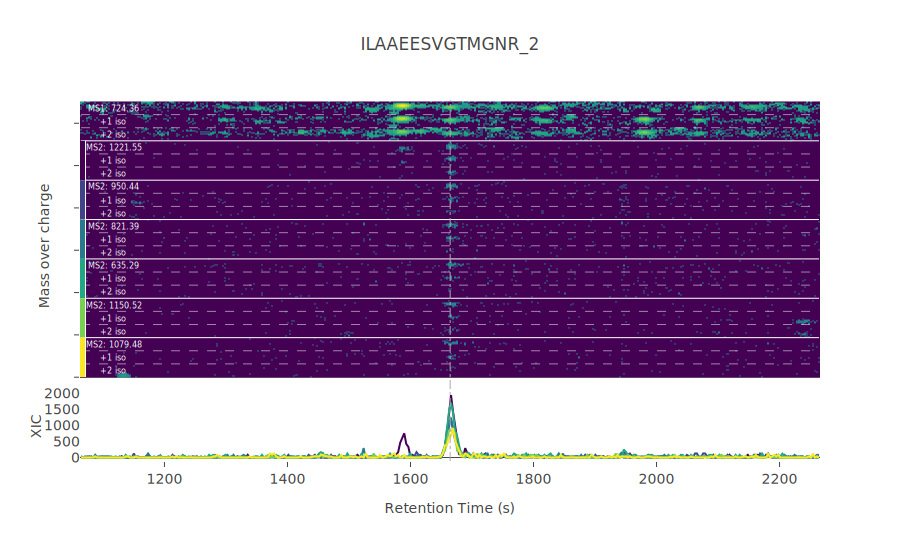

In [8]:
transition_groups = [
    ('TPVISGGPYYER_2', 1779.903),
    ('LLPSESALLPAPGSPYGR_2', 3304.652),
    ('LLPSESALLPAPGSPYGR_2', None),
    ('ILAAEESVGTMGNR_2', 1664.507),
]

for transition_group, retention_time_line in transition_groups:
    precursors_tg = precursors.loc[transition_group].IsotopeMz.tolist()
    products_tg = products.loc[transition_group].IsotopeMz.tolist()[:6 * (1 + n_isotopes)]

    zoom = True and retention_time_line is not None

#     output_fname = None
    output_fname = f'toffee_fragments.{transition_group}-zoom_{zoom}.svg'
    kwargs = dict(
        psm_name=transition_group,
        number_of_isotopes=n_isotopes,
        retention_time_line=retention_time_line,
        output_fname=output_fname,
    )

    if zoom:
        delta_rt = 600
        kwargs['retention_time_zoom'] = [retention_time_line - delta_rt, retention_time_line + delta_rt]
        kwargs['aspect_scale'] = 0.15

    figure = plotter.create_plotly_figure(
        precursors_tg,
        products_tg,
        **kwargs,
    )
    if output_fname is not None:
        display(SVG(output_fname))
        os.remove(output_fname)
    elif figure is not None:
        po.iplot(figure, show_link=False)